In [1]:
import math
import copy
from task import Task
from caseLoader import CaseLoader
from taskType import TaskType
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
# global variable :D
rand = random.Random()

def get_ready(task_set, cycle, ready_list):
    for task in task_set:
        if cycle % task.period == 0:
            new_job = copy.deepcopy(task)
            new_job.deadline = new_job.deadline + cycle
            new_job.release_time = cycle
            ready_list.append(new_job)
    
    # sort on deadline
    # https://www.geeksforgeeks.org/sorting-objects-of-user-defined-class-in-python/
    ready_list = sorted(ready_list, key=lambda t: t.deadline) 
    
    return ready_list
        

# ts is set of TT tasks
def edf(ts):
    #print("in edf: ", ts[-1].name, ts[-1].duration, ts[-1].period, ts[-1].deadline)
    periods = [t.period for t in ts]
    T = math.lcm(*periods) # least common multiple of TT task periods. 2000 mt = 
    #print(T)
    s = [] # schedule will be hyperperiod long. 12 000 microticks == 120 000 microsecs == 120 ms
    ready_list = []
    wcrts = {} # worst case response times
    
    # overvej reset funktioner i task klassen istedet for alle de kopier...
    for t in range(0, T):
        for task in ready_list:
            if task.duration > 0 and task.deadline <= t:
                #print(t)
                #for task in ready_list:
                #    print("name: ", task.name, " duration: ", task.duration, " deadline: ", task.deadline, " period: ", task.period, " release: ", task.release_time)
                return s, -1
        
            # job done check response time gt wcrt and remove from ready list
            if task.duration == 0 and task.deadline >= t:
                response_time = t - task.release_time
                
                if task.name not in wcrts or response_time >= wcrts[task.name]:
                    wcrts[task.name] = response_time
                
                ready_list.remove(task)
                
        # release taks at time t
        ready_list = get_ready(ts, t, ready_list)

        if ready_list == []:
            s.append("IDLE")
            continue
        else:
            # EDF get next job to execute 
            s.append(ready_list[0].name)
            ready_list[0].duration = ready_list[0].duration - 1
    
    if ready_list != []:
        return [], wcrts
    
    #print("in EDF wcrts is: ", wcrts)
    
    return s, wcrts

In [3]:
def unpack(task):
    return (task.priority, task.duration, task.period, task.deadline)

#Schedulability of ET tasks under a given polling task
def calculate_schedulabiltiy(ps, task_periods):
    Tp = ps.period
    Dp = ps.deadline
    Cp = ps.duration
    result_dict = {}
    
    #compute delta and alpha accordingly to [2]
    Delta = Tp + Dp - 2*Cp
    alpha = Cp/Tp
    
    #hyperperiod is lcm of all task periods in T_ET (all values must be from the chosen subset of ET tasks from the .csv)
    periods = [t.period for t in task_periods]
    #for task in task_periods:
    #    (pi, Ci, Ti, Di) = unpack(task)
    #    periods.append(Ti)

    
    hyperperiod = math.lcm(*periods)
    #print("hyperperiod ets is ", hyperperiod)

    for task_period in task_periods:
        (pi, Ci, Ti, Di) = unpack(task_period)
        t = 0
        #initialize the response time of ti (task period) to a value exceeding the deadline
        response_time = Di + 1

        #remember we are dealing with constrained deadline tasks for the AdvPoll, hence, in the worst case arrival pattern, the intersection must lie within the hyperperiod if the task is schedulable

        while t <= hyperperiod:
            #the supply at time t ([1])
            supply = alpha*(t-Delta)

            #compute the maximum demand at time t according to Eq. 2
            demand = 0
            for tj in task_periods:
                (pj, Cj, Tj, Dj) = unpack(tj)

                if pj >= pi:
                    demand  = demand + math.ceil(t/Tj)*Cj
            
            #According to lemma 1 of [1], we are searching for the earliest time, when the supply exceeds the demand
            if supply >= demand:
                response_time = t
                result_dict[task_period.name]  = (True, response_time, task_period.deadline) # if actually greater than deadline, set to false later
                break
            
            t = t + 1
        
        if response_time > Di:
            result_dict[task_period.name] = (False, response_time, task_period.deadline)
            
        
    return result_dict # contains wcrt and bool indicating schedulability for each et



def cost_f(task_set):
    
    polling_servers = [ps for ps in task_set if ps.et_subset != None]
    
    l = [calculate_schedulabiltiy(ps, ps.et_subset) for ps in polling_servers]
    #ps = polling_servers[0]
    # https://www.geeksforgeeks.org/reduce-in-python/
    # create list of bools by applying schedulability check for ets, fold into single bool using and.
    
    #print("*****************")
    wcrts_et = 0
    is_schedulable = True
    for entry in l:
        #print("len entry: ", len(entry))
        wcrts_et += (sum([(entry[key][1] / entry[key][2]) if entry[key][0] else 1 for key in entry]) / len(entry))
        is_schedulable = is_schedulable and reduce((lambda a, b : a and b), [entry[key][0] for key in entry])
    
    
    if l != []:
        wcrts_et *= 1/len(l) 
    
    s, wcrts = edf(task_set)
    
    if wcrts == -1:
        return s, 2, False
    
    #print("IN COST not -1")
    sum_wcrts_tt = sum([wcrts[task.name] / task.deadline for task in task_set])
    #sum_wcrts_tt = sum([wcrts[key][0] / wcrts[key][1]  for key in wcrts])
    #print("in cost: ", sum_wcrts_tt)
    
    #return s, sum_wcrts_tt
    
    #alternative 0 <= sum <= 1
    sum_wcrts_tt = sum_wcrts_tt / len(task_set)
    sum_wcrts = (sum_wcrts_tt + wcrts_et)
    
    assert 0 <= sum_wcrts and sum_wcrts <= 2
    
    return s, sum_wcrts, is_schedulable

In [4]:
NUM_PS = 0
BUDGET = 1
PERIOD = 2
DEADLINE = 3
SUBSET = 4

# hardcode mins and max duration,period, deadline for now
def create_random_ps(et_subset): 
    # try like this bc hyperperiod thing if very long we visit very few solutions 
    periods = [1000, 2000,3000,4000]
    period = periods[rand.randint(0,len(periods)-1)]
    deadline = max(period, (rand.randint(1, 40) * 100))
    
    
    duration = rand.randint(1, 500) # this seems like cheating hardcoding range
    #period = rand.randint(1, 50) * 100 # multiple of 100 to avoid hyperperiod exploding??
    #deadline = max(period, (rand.randint(1, 50) * 100)) 
    
    # find naming scheme,have to b unique, requires counting or sth, some state 
    return Task("tTTps" + str(rand.randint(1,100000)), duration, period, TaskType.TIME, 7, deadline, et_subset)

# not even guaranteed to return...
def create_random_schedulable_ps(et_subset):
    
    is_schedulable = False
    while not is_schedulable:
        is_schedulable = True
        ps = create_random_ps(et_subset)
        d = calculate_schedulabiltiy(ps, et_subset)
        is_schedulable = is_schedulable and reduce((lambda a, b : a and b), [d[key][0] for key in d])
    
    ps.et_subset = et_subset
    return ps

# get a subset of pses from victim and delete these from victim
# -1 to not steal all, max (1, otherthing) to not get rand(1, -x)
def create_ps_subset(victim_ps):
    num_et_tasks = rand.randint(1, max(1, len(victim_ps.et_subset) - 1)) 
    new_ps_et_subset = []
        
    
    for task in victim_ps.et_subset[0:num_et_tasks]:
        new_ps_et_subset.append(task)
    
    # do not know how removing and iterating at same time works so do like this 
    for task in victim_ps.et_subset[0:num_et_tasks]:
        victim_ps.et_subset.remove(task)
    
    #for t in new_ps_et_subset:
        #print(t.deadline)
    return new_ps_et_subset

def create_ps(ps_id):
    return 0

# when removing a ps
def merge_ps_subsets(ps_giver, ps_receiver):
    ps_receiver.et_subset += ps_giver.et_subset        
        

# define a function to just 
    
# take polling servers as arg, 
def neighborhood(polling_servers):
    # num_ps, period, budget, deadline, subset
    
    # select parameter to change. skip adding/removing ps for now
    parameter = rand.randint(0, 3)
    
    # sel
    victim_ps = polling_servers[rand.randint(0,len(polling_servers) - 1)] # victim to change etc.
    
    # increase or decrease chosen parameter
    sign = 1 if rand.randint(0,1) == 0 else -1
    
    # only adds a polling server. add functionality to remove one and move et subset to other ps
    if parameter == NUM_PS:
        if sign == 1:
            new_et_subset = create_ps_subset(victim_ps)
            new_ps = create_random_ps(new_et_subset)
            #new_ps = Task("tTT" + str(rand.randint(0,5000)), 500, 1000, TaskType.TIME, 7, 1000, new_et_subset)
            polling_servers.append(new_ps)
            
            if victim_ps.et_subset == []:
                polling_servers.remove(victim_ps)
            
        else:
            if len(polling_servers) > 1:
                ps_giver = polling_servers[rand.randint(0, len(polling_servers) - 1)]
                ps_receiver = polling_servers[rand.randint(0, len(polling_servers) - 1)]
                while ps_receiver == ps_giver:
                    ps_receiver = polling_servers[rand.randint(0, len(polling_servers) - 1)]
                
                merge_ps_subsets(ps_giver, ps_receiver)
                
                polling_servers.remove(ps_giver)
                
        #return polling_servers + [new_ps]
    elif parameter == BUDGET:
        victim_ps.duration = max(1, victim_ps.duration + sign * 10)
        
    elif parameter == PERIOD:
        victim_ps.period = max(5, victim_ps.period + sign * 100)
        victim_ps.period = max(victim_ps.period, victim_ps.deadline) # do not accept period < deadline for now 

    elif parameter == DEADLINE:
        victim_ps.deadline = max(5, victim_ps.deadline + sign * 100)
        victim_ps.deadline = min(victim_ps.period, victim_ps.deadline) # do not accept period < deadline for now 
        #maybe not even necessary just return infeasible stuff let sa handle it 
    
    elif parameter == SUBSET:
        if len(polling_servers) == 1: # if no one to steal from 
            return polling_servers 
        other_ps_victim = polling_servers[rand.randint(0, len(polling_servers) - 1)]

        while other_ps_victim == victim_ps:
            other_ps_victim = polling_servers[rand.randint(0, len(polling_servers) -1)]
            
        new_ps_et_subset = get_subset(polling_servers, other_ps_victim)
        
        victim_ps.et_subset += new_ps_et_subset
        
    return polling_servers # should be copy no?

In [5]:
def p(delta, t):
    return np.exp( -delta / t )

# simulated annealing 
def sa(s0, t, a, stopcriterion_sec, neighborhood_f = None, cost_f=None, log_costs = False):
    # initialize variables
    sec0 = int(time.time())
    sec_now = int(time.time())
    
    # get tt and et tasks
    tt = [t for t in s0 if t.type == TaskType.TIME and t.et_subset == None]
    et = [t for t in s0 if t.type == TaskType.EVENT]
    polling_servers = [t for t in s0 if t.et_subset != None]
    
    # current and best solution
    current_solution = tt + polling_servers
    schedule, current_cost, is_schedulable = cost_f(current_solution)
    best_solution = copy.deepcopy(current_solution)
    best_cost = current_cost
    best_ps_config = polling_servers
    
    print("cost 0: ", current_cost)
     
    # 1 entry pr. cycle in hyperperiod
    #schedule = []
    
    # for logging purposes
    n_solutions = 0
    cost_log = []
    
    # does not matter if < or <= if 0 then new solution will be selected no matter what     
    while int(time.time()) - sec0 < stopcriterion_sec:
        # obtain ps configuration from neighborhood. create temporary solution
        tmp_ps = neighborhood_f(copy.deepcopy(polling_servers)) # feel like we should call with a copy?
        tmp_solution = tt + tmp_ps
        
        
        #if(tmp_ps.deadline == )
        #print("cur sol: ", current_solution[-1].duration, current_solution[-1].period, current_solution[-1].deadline)
        #print("tmp sol: ", tmp_solution[-1].duration, tmp_solution[-1].period, tmp_solution[-1].deadline)
        tmp_schedule, tmp_cost, is_schedulable = cost_f(tmp_solution)
        
        # compute delta
        delta = tmp_cost - current_cost
        
        # logging
        n_solutions = n_solutions + 1
        
       # print("p is: ", p(delta, t), "t is: ", t, "delta is: ", delta, "tmp_cost is: ", tmp_cost)
        #for ps in tmp_ps:
        #    print("current ps: name: ", ps.name, " duration: ", ps.duration, " deadline: ", ps.deadline, " period: ", ps.period)
        
        #if delta > 0:
        #    print("delta: ", delta, " t: ", t, " p(delta, t): ", p(delta, t), is_schedulable)
        # accept randomly drawn solution from current neighborhood if better or with some probability
        if delta <= 0 or p(delta, t) > rand.uniform(0.0, 1.0):
            #print("yo")
            polling_servers = copy.deepcopy(tmp_ps) # all these copies...
            current_solution = tmp_solution # update current solution, current set of polling servers, costs & schedule
            current_cost = tmp_cost
            tmp_cost = tmp_schedule[:]
            
            ps = current_solution[-1]
            #print("update solution ps config. name: ", ps.name, " duration: ", ps.duration, " period: ", ps.period, " deadline: ", ps.deadline)
                        
            if log_costs: # logging
                cost_log.append(current_cost)
            
            # keep track of the best solution. save all the things..
            if current_cost < best_cost and is_schedulable:
                best_solution = current_solution
                best_schedule = schedule[:]
                best_cost = current_cost
                best_ps_config = copy.deepcopy(polling_servers)
                print("updated best solution")
                #print("HELO")
                
        # update temperature 
        t = t * a
    
    print("Total generated solutions: ", n_solutions)
    print("Visited solutions:         ", len(cost_log))
    return (schedule, best_cost, cost_log, best_ps_config) if log_costs else (schedule, best_cost, best_ps,config) 
    

In [6]:
loader = CaseLoader()
all_tasks = loader.load_test_case("inf_10_10", 0)
tt_tasks = [t for t in all_tasks if t.type == TaskType.TIME]
et_tasks = [t for t in all_tasks if t.type == TaskType.EVENT]


Searching for test cases at:
./test_cases/inf_10_10
Loaded case_group: inf_10_10 - case: 0 test case(s).


In [7]:
polling_servers_0 = [Task("tTTps00",500, 1000, TaskType.TIME, 7, 1000, et_tasks)]
#polling_servers_0 = [Task("tTTps00",100, 100, TaskType.TIME, 7, 100, et_tasks)]
#polling_servers_0 = [create_random_ps(et_tasks)]
#polling_servers_0 = [create_random_schedulable_ps(et_tasks)]

task_set = tt_tasks + polling_servers_0
print("name: ", task_set[-1].name, " duration: ", task_set[-1].duration, " deadline: ", task_set[-1].deadline, " period: ", task_set[-1].period, task_set[-1].release_time)

name:  tTTps00  duration:  500  deadline:  1000  period:  1000 0


In [8]:
schedule, cost_best, cost_log, best_ps_config = sa(task_set, 2, .99, 60, neighborhood_f = neighborhood, cost_f=cost_f, log_costs=True)

cost 0:  0.9000118710770846
updated best solution
updated best solution
updated best solution
updated best solution
Total generated solutions:  44
Visited solutions:          43


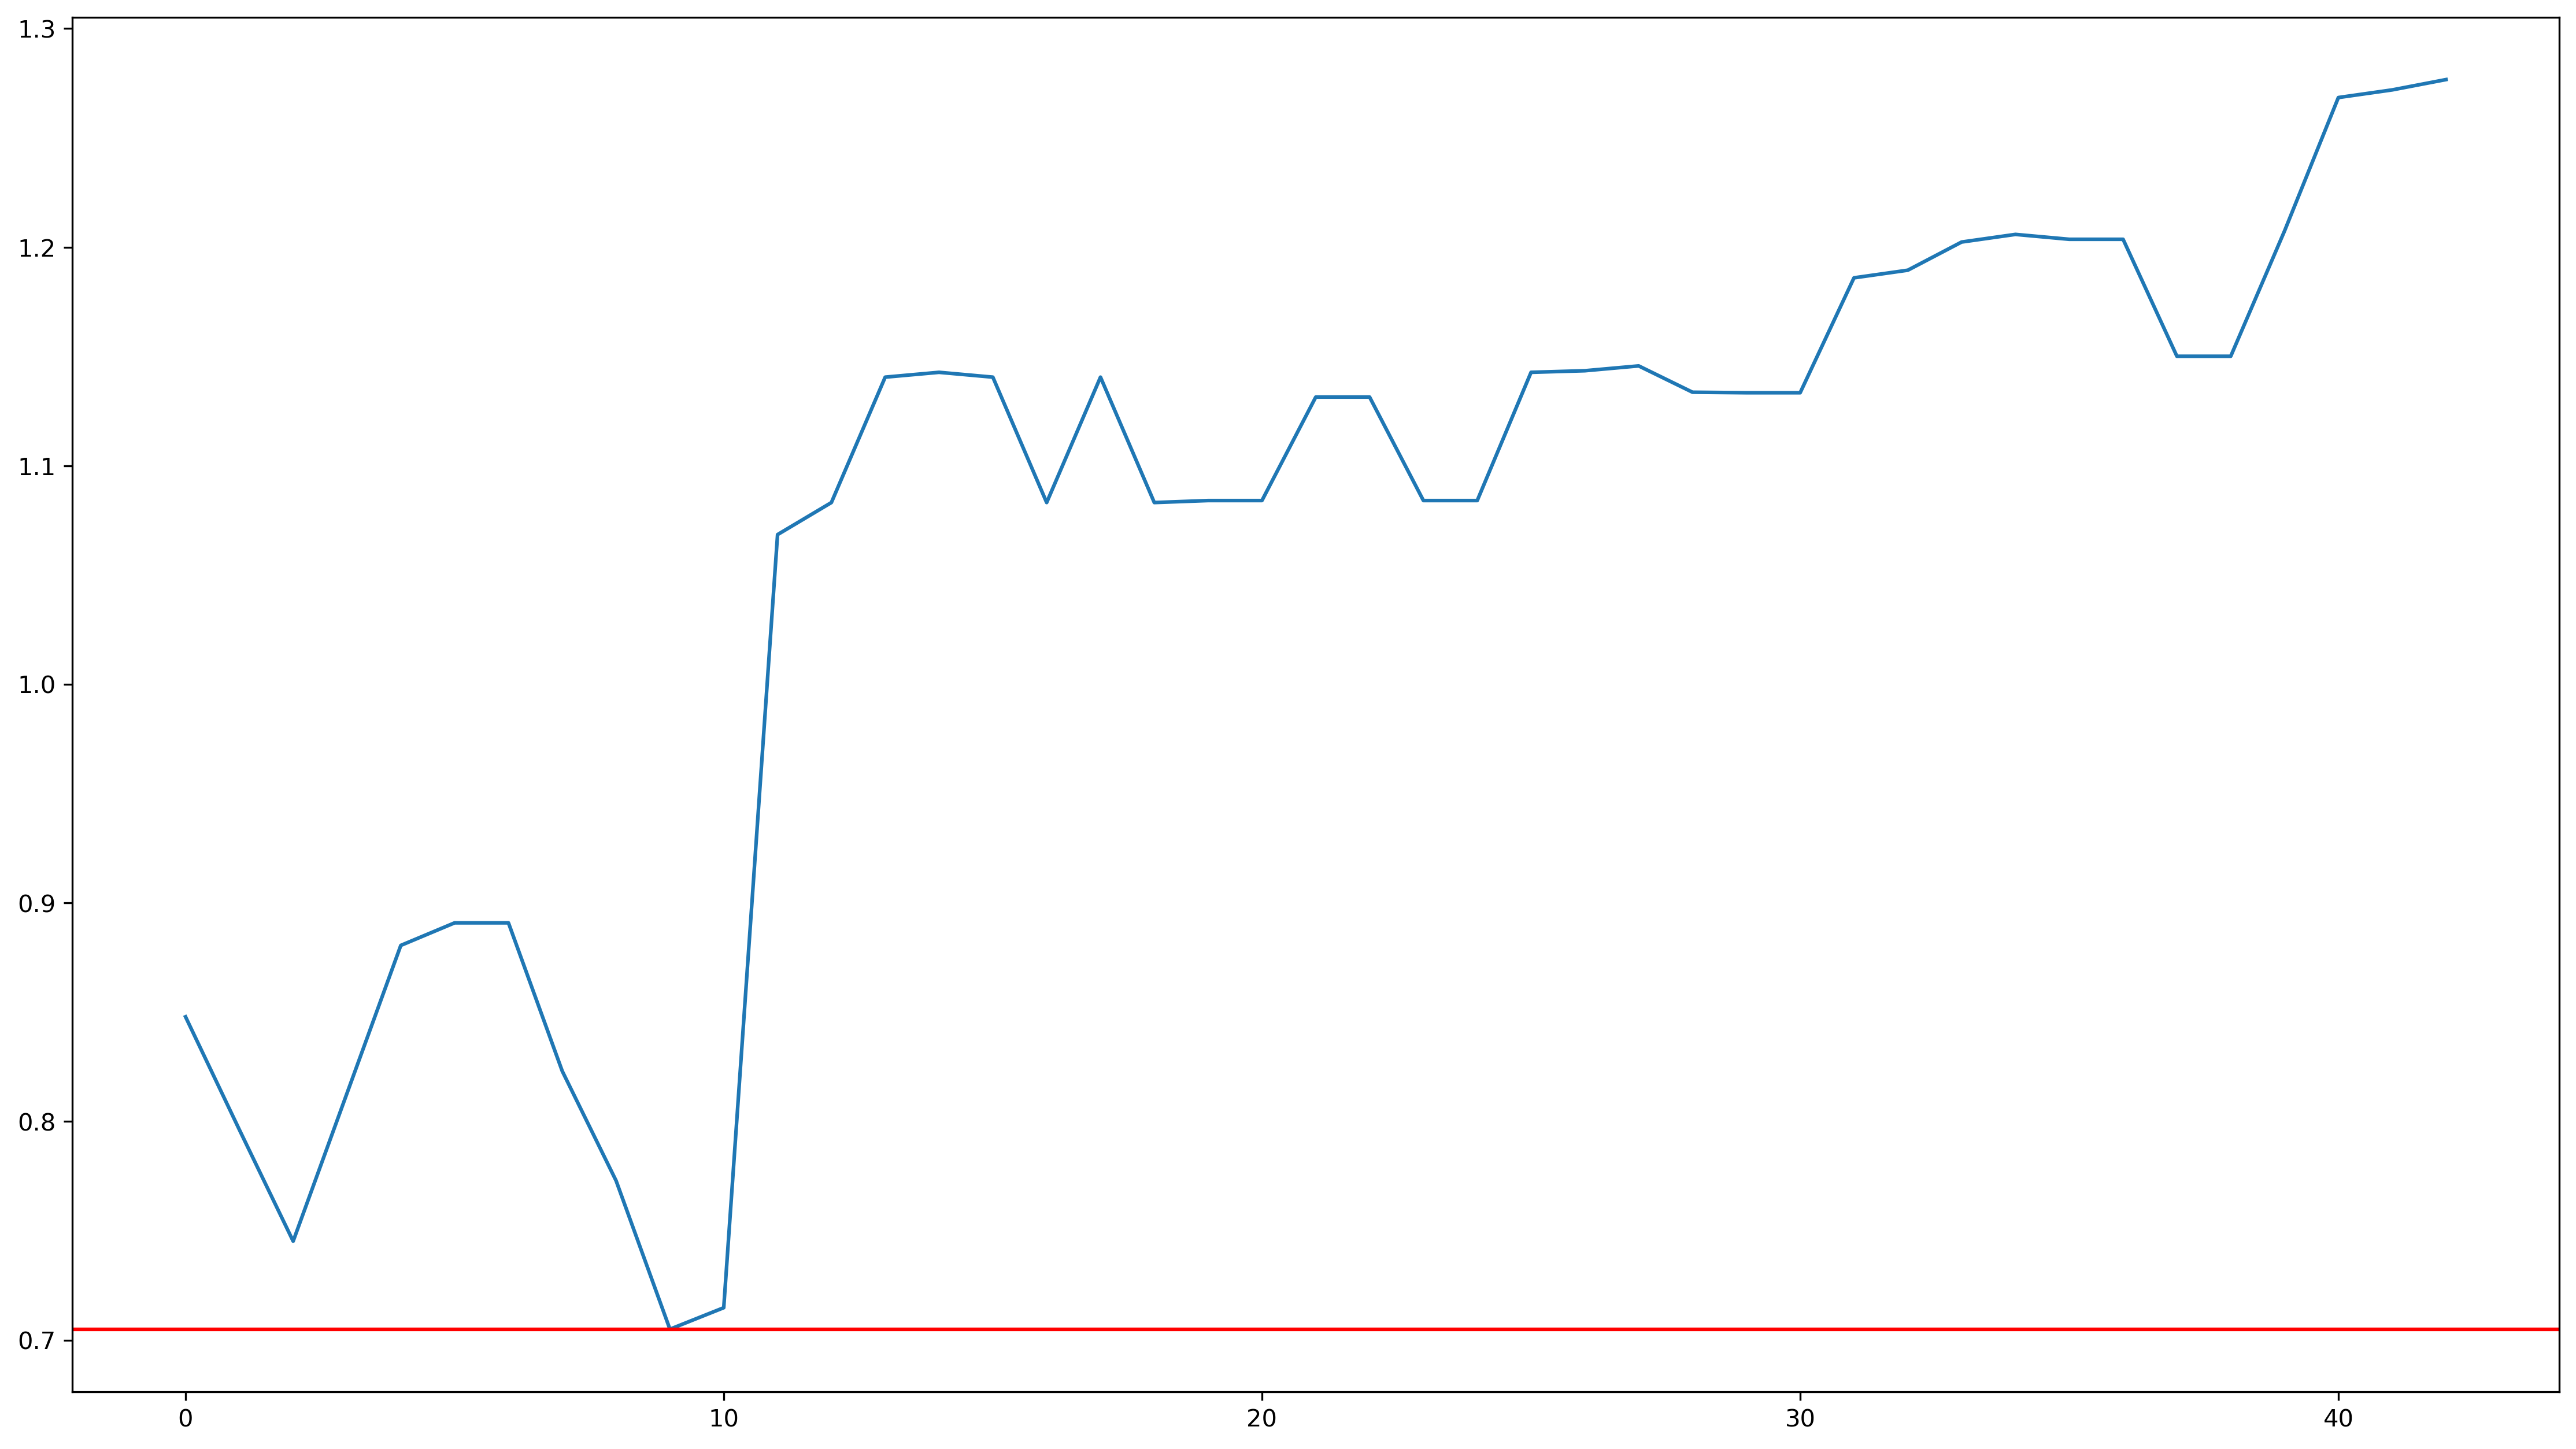

In [9]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
plt.axhline(y = cost_best, color = 'r', linestyle = '-')
fig.set_dpi(300)
#plt.savefig("pretty.pdf")

In [18]:
s, cost, is_ = cost_f(tt_tasks + best_ps_config)

In [19]:
print(cost_best)
calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset)

0.436658775426762


{'tET4': (True, 600, 2998),
 'tET12': (True, 600, 2968),
 'tET15': (True, 545, 2697),
 'tET16': (True, 513, 2516),
 'tET11': (True, 513, 2492),
 'tET19': (True, 513, 2437),
 'tET3': (True, 513, 2406),
 'tET0': (True, 513, 2395),
 'tET7': (True, 513, 2233),
 'tET6': (True, 513, 1951),
 'tET13': (True, 371, 1922),
 'tET8': (True, 371, 1774),
 'tET2': (True, 298, 1761),
 'tET17': (True, 298, 1627),
 'tET5': (True, 298, 1623),
 'tET1': (True, 298, 1617),
 'tET14': (True, 298, 1340),
 'tET10': (True, 249, 1220),
 'tET18': (True, 249, 1202),
 'tET9': (True, 249, 1197)}

In [22]:
best_ps_config[0].duration

# good config duration = 449, period = 600, deadline = 500

350

In [23]:
len(best_ps_config[0].et_subset)

20

In [24]:
s, wcrts = edf(tt_tasks + best_ps_config)

In [25]:
wcrts

{'tTTps00': 350,
 'tTT1': 354,
 'tTT6': 357,
 'tTT8': 359,
 'tTT9': 360,
 'tTT14': 371,
 'tTT15': 374,
 'tTT22': 380,
 'tTT27': 382,
 'tTT2': 386,
 'tTT4': 408,
 'tTT5': 423,
 'tTT7': 432,
 'tTT10': 436,
 'tTT11': 461,
 'tTT12': 471,
 'tTT13': 487,
 'tTT16': 490,
 'tTT23': 862,
 'tTT24': 892,
 'tTT25': 897,
 'tTT0': 902,
 'tTT3': 915,
 'tTT17': 949,
 'tTT18': 962,
 'tTT19': 978,
 'tTT20': 989,
 'tTT21': 997,
 'tTT26': 998,
 'tTT28': 1367,
 'tTT29': 1380}

In [32]:
s, c, i = cost_f(tt_tasks)
c * 10

0.4059166666666667

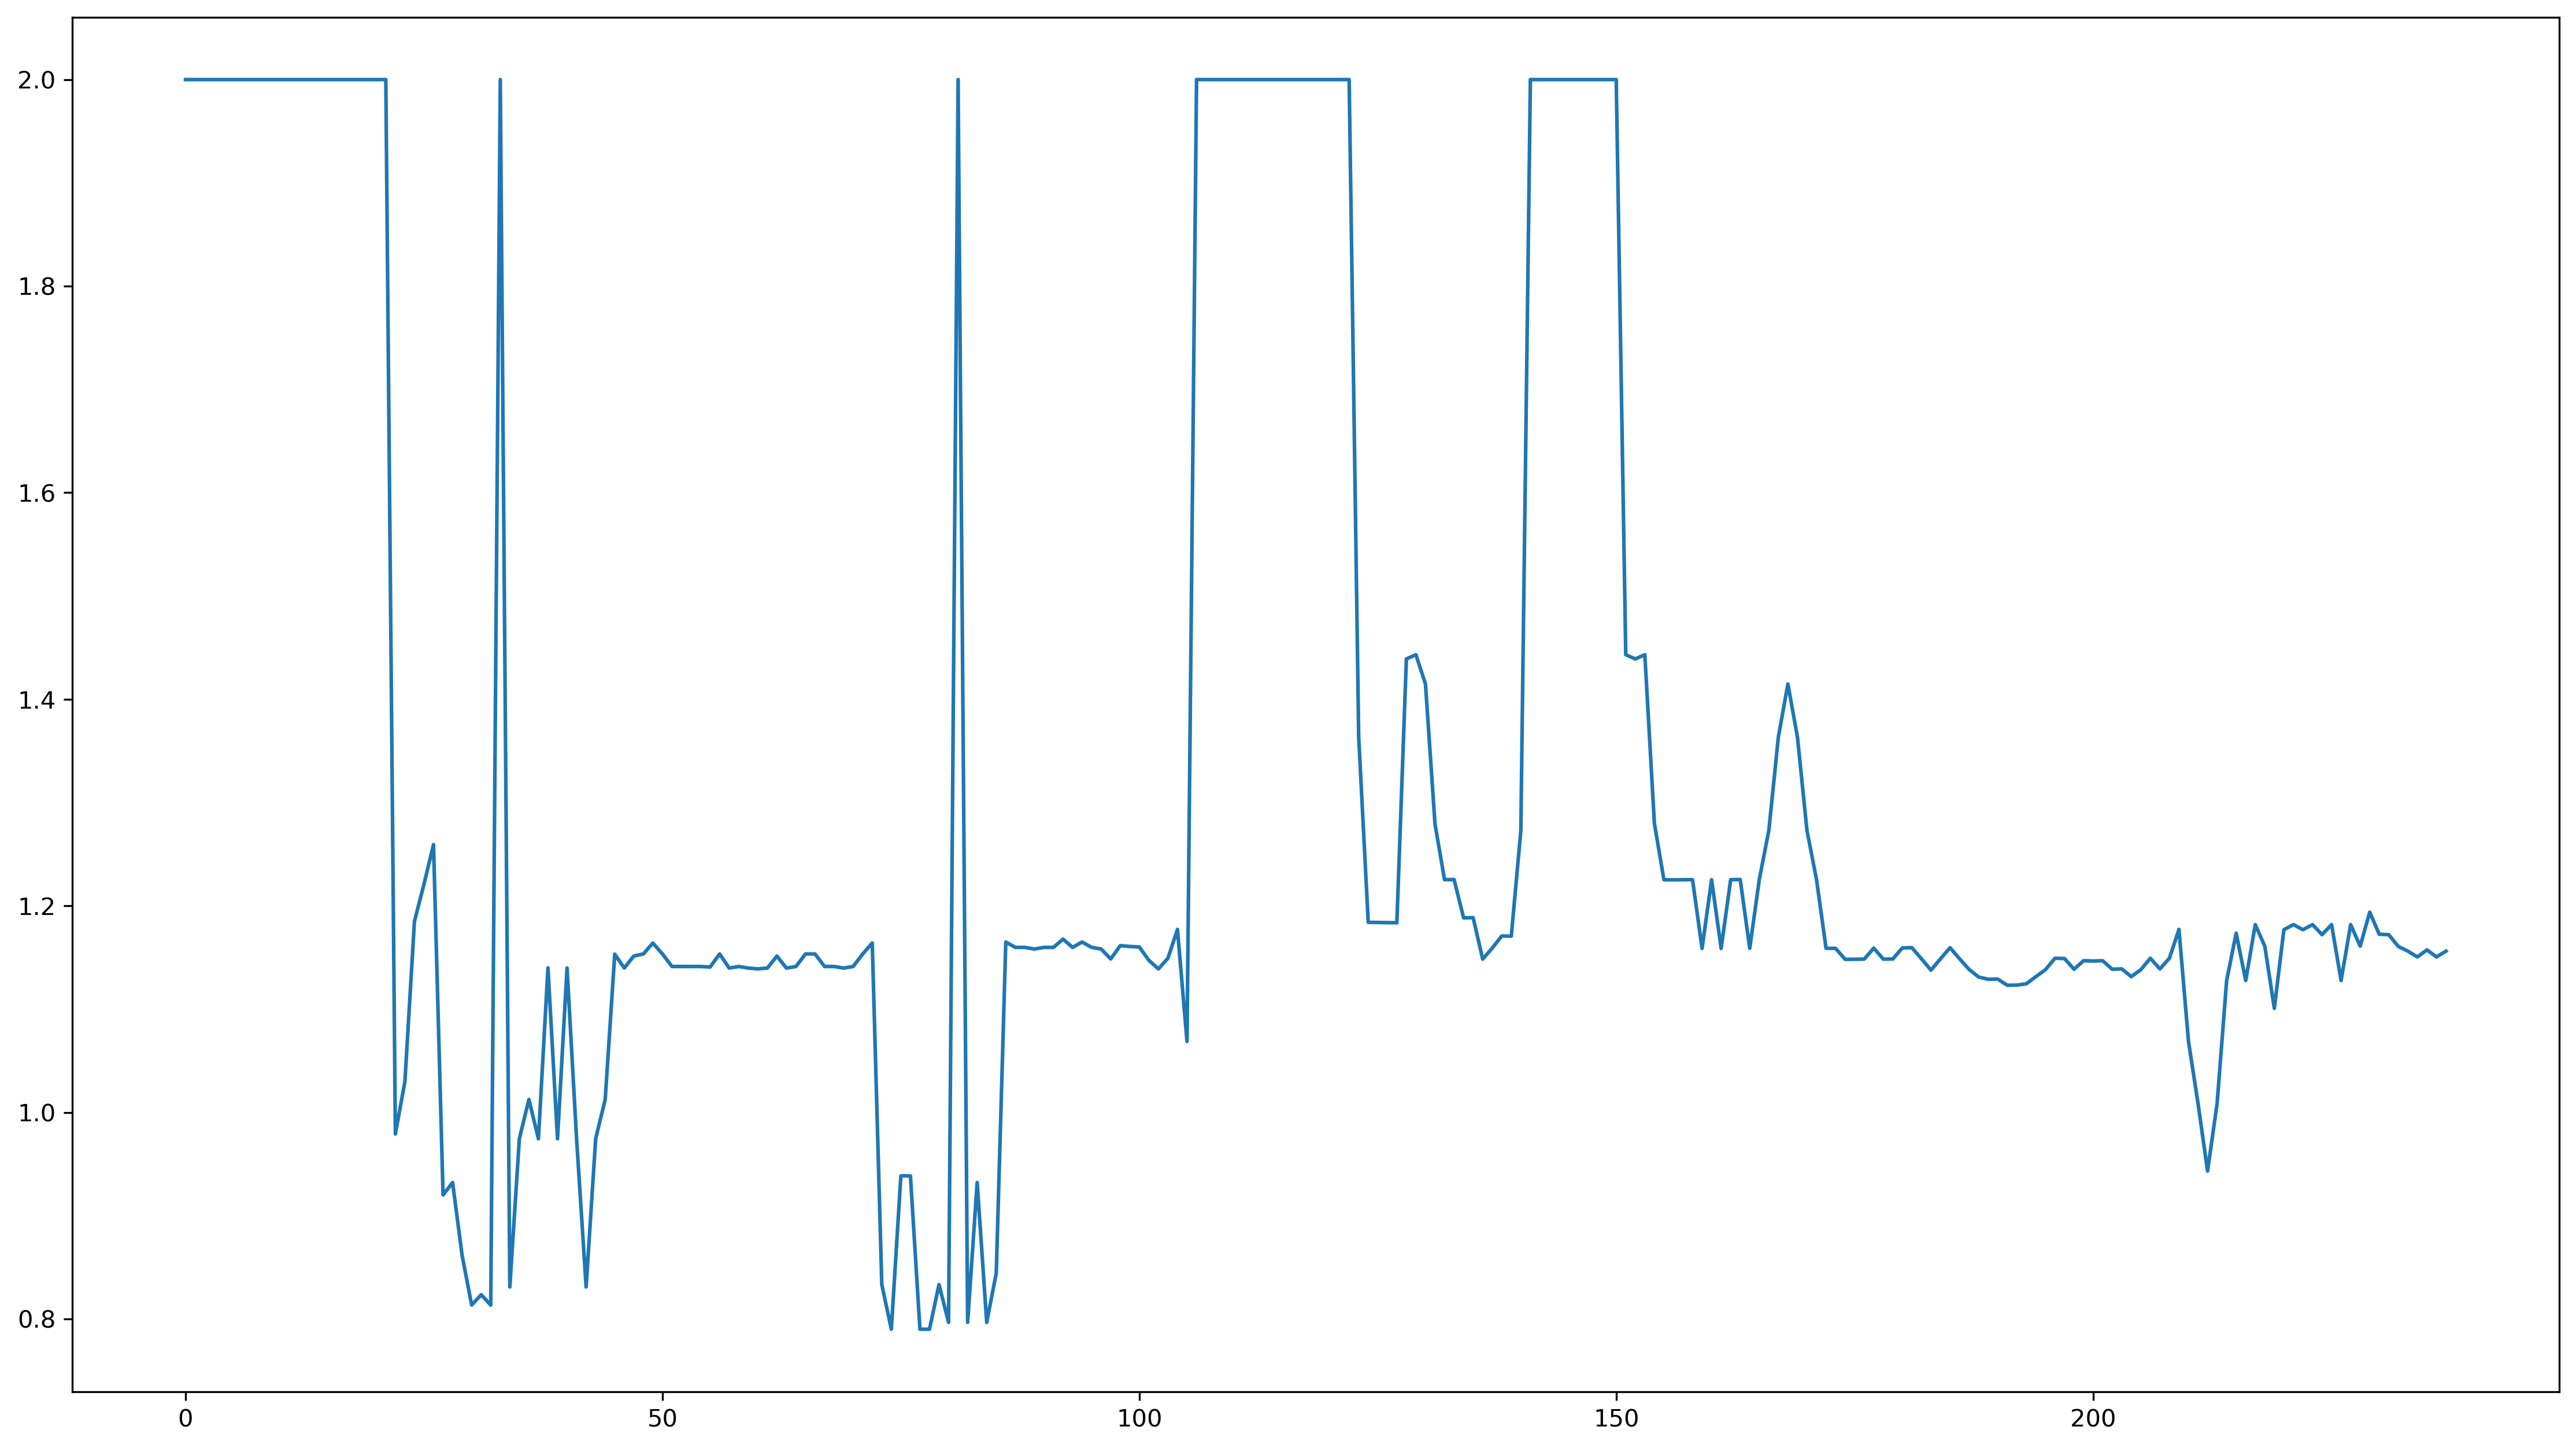

In [55]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)


In [56]:
#print(calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset))
print(best_ps_config[0].duration, best_ps_config[0].period, best_ps_config[0].deadline)
#calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset)

s, cost, is_ = cost_f(tt_tasks + best_ps_config)

50 105 105


In [57]:
calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset)

{'tET10': (True, 1814, 3613),
 'tET0': (True, 1814, 2831),
 'tET16': (True, 1669, 2796),
 'tET15': (True, 1669, 2793),
 'tET18': (True, 1289, 2763),
 'tET7': (True, 1289, 2487),
 'tET8': (True, 1289, 2479),
 'tET5': (True, 1207, 2377),
 'tET6': (True, 1207, 2328),
 'tET17': (True, 1207, 2275),
 'tET2': (True, 1207, 2252),
 'tET9': (True, 1207, 1996),
 'tET13': (True, 1207, 1972),
 'tET12': (True, 860, 1778),
 'tET11': (True, 814, 1727),
 'tET3': (True, 776, 1455),
 'tET19': (True, 776, 1446),
 'tET14': (True, 776, 1406),
 'tET4': (True, 776, 1377),
 'tET1': (True, 776, 1075)}

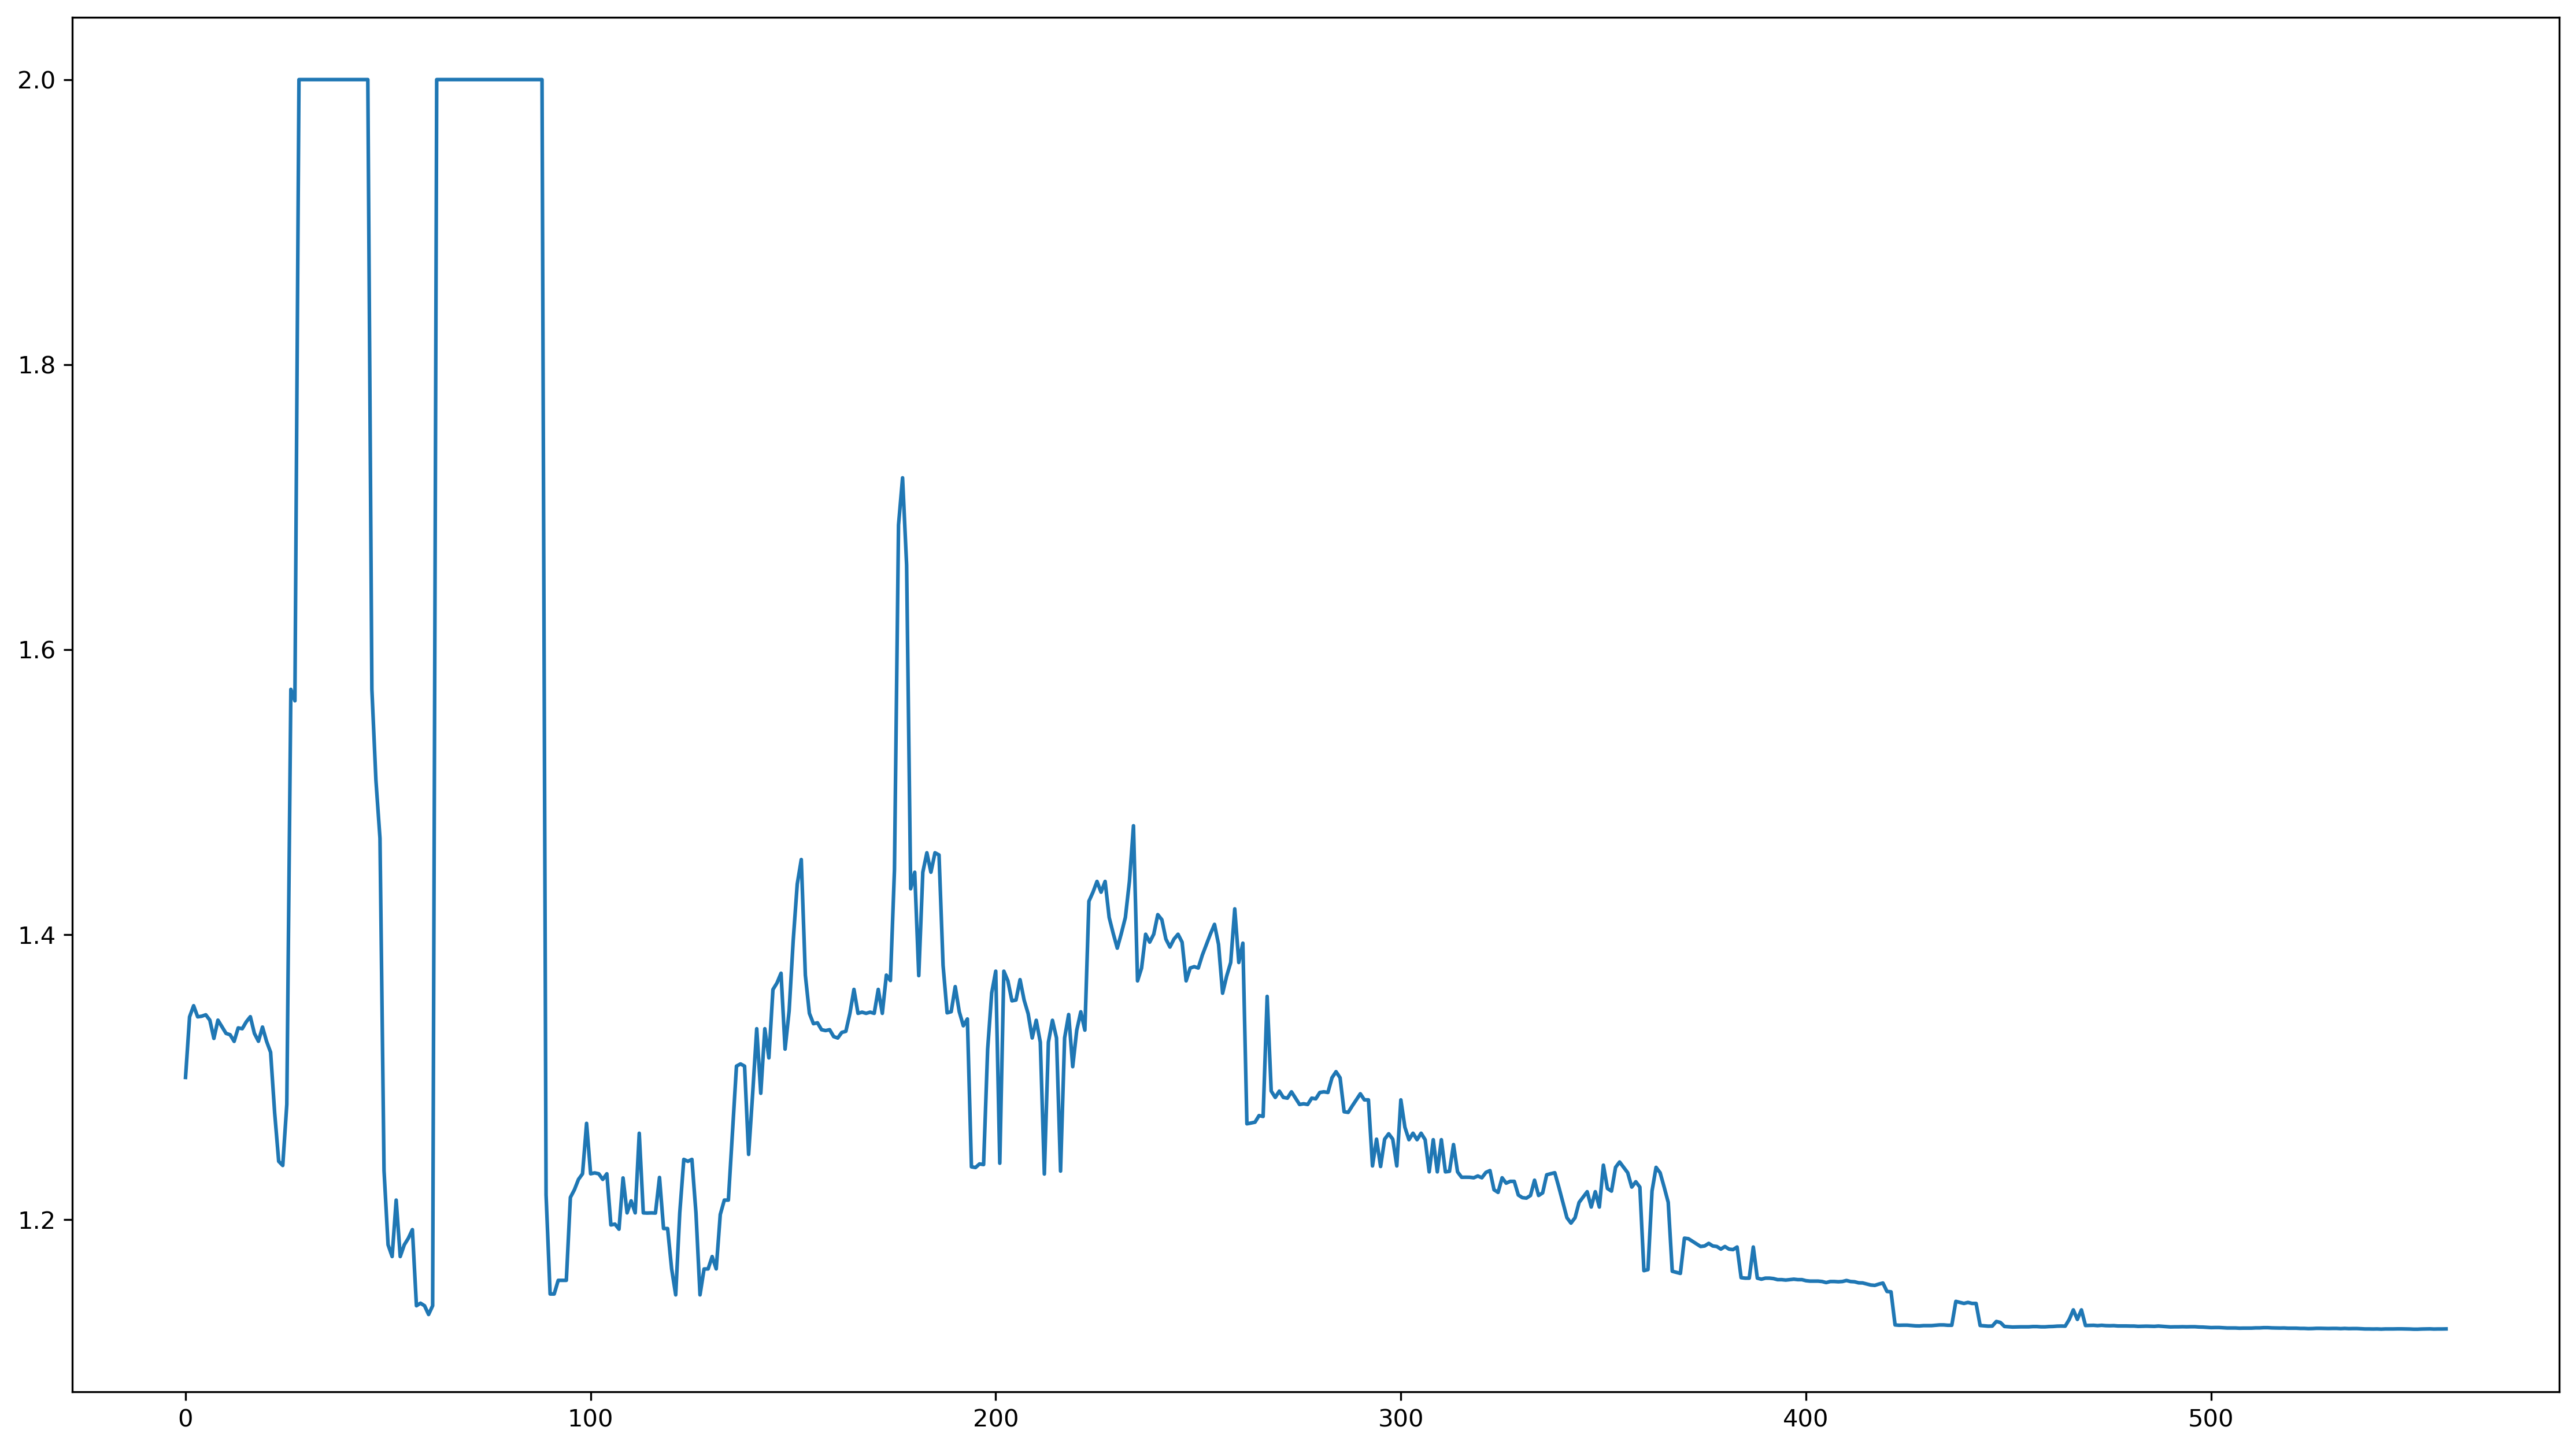

In [56]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)
#plt.savefig('yoooo_op_og_ned_hva_1.pdf')  

In [61]:
#print(calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset))
print(best_ps_config[0].duration, best_ps_config[0].period, best_ps_config[0].deadline)
#calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset)

#cost_f(tt_tasks + best_ps_config)

440 700 800


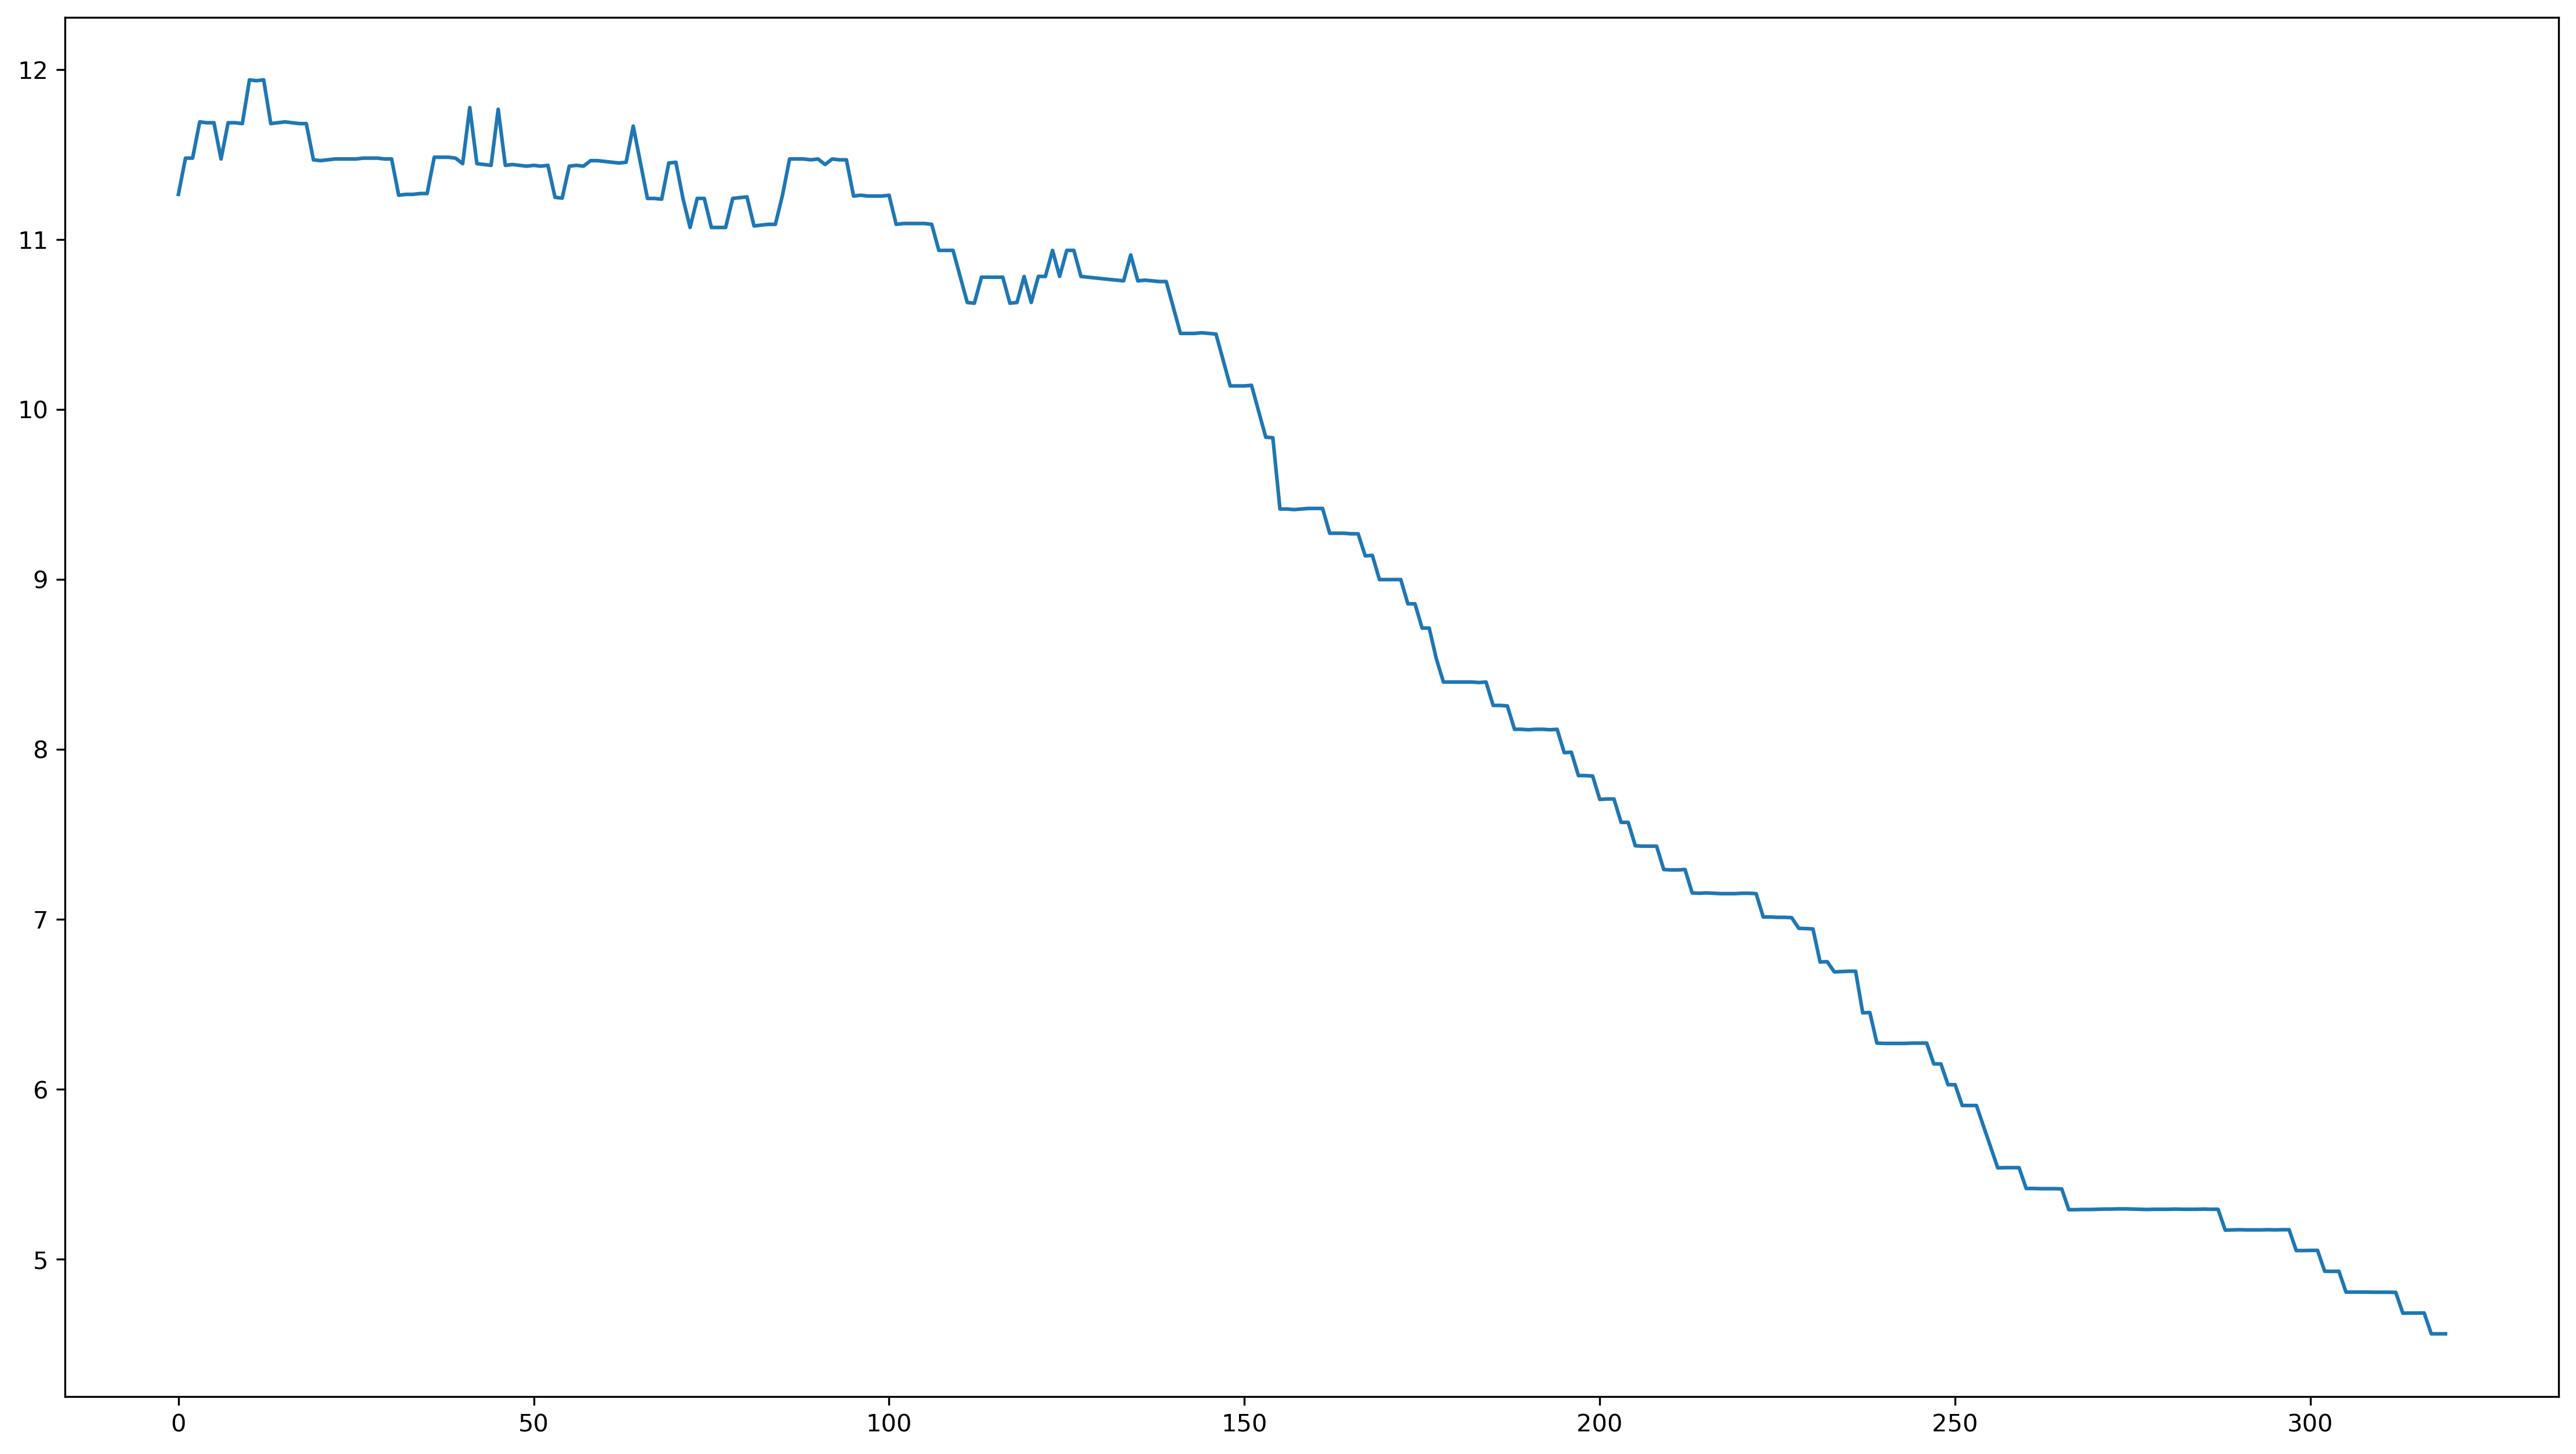

In [252]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)
#plt.savefig('yoooo_op_og_ned_hva_1.pdf')  

In [256]:
best_ps_config[0].deadline

1070

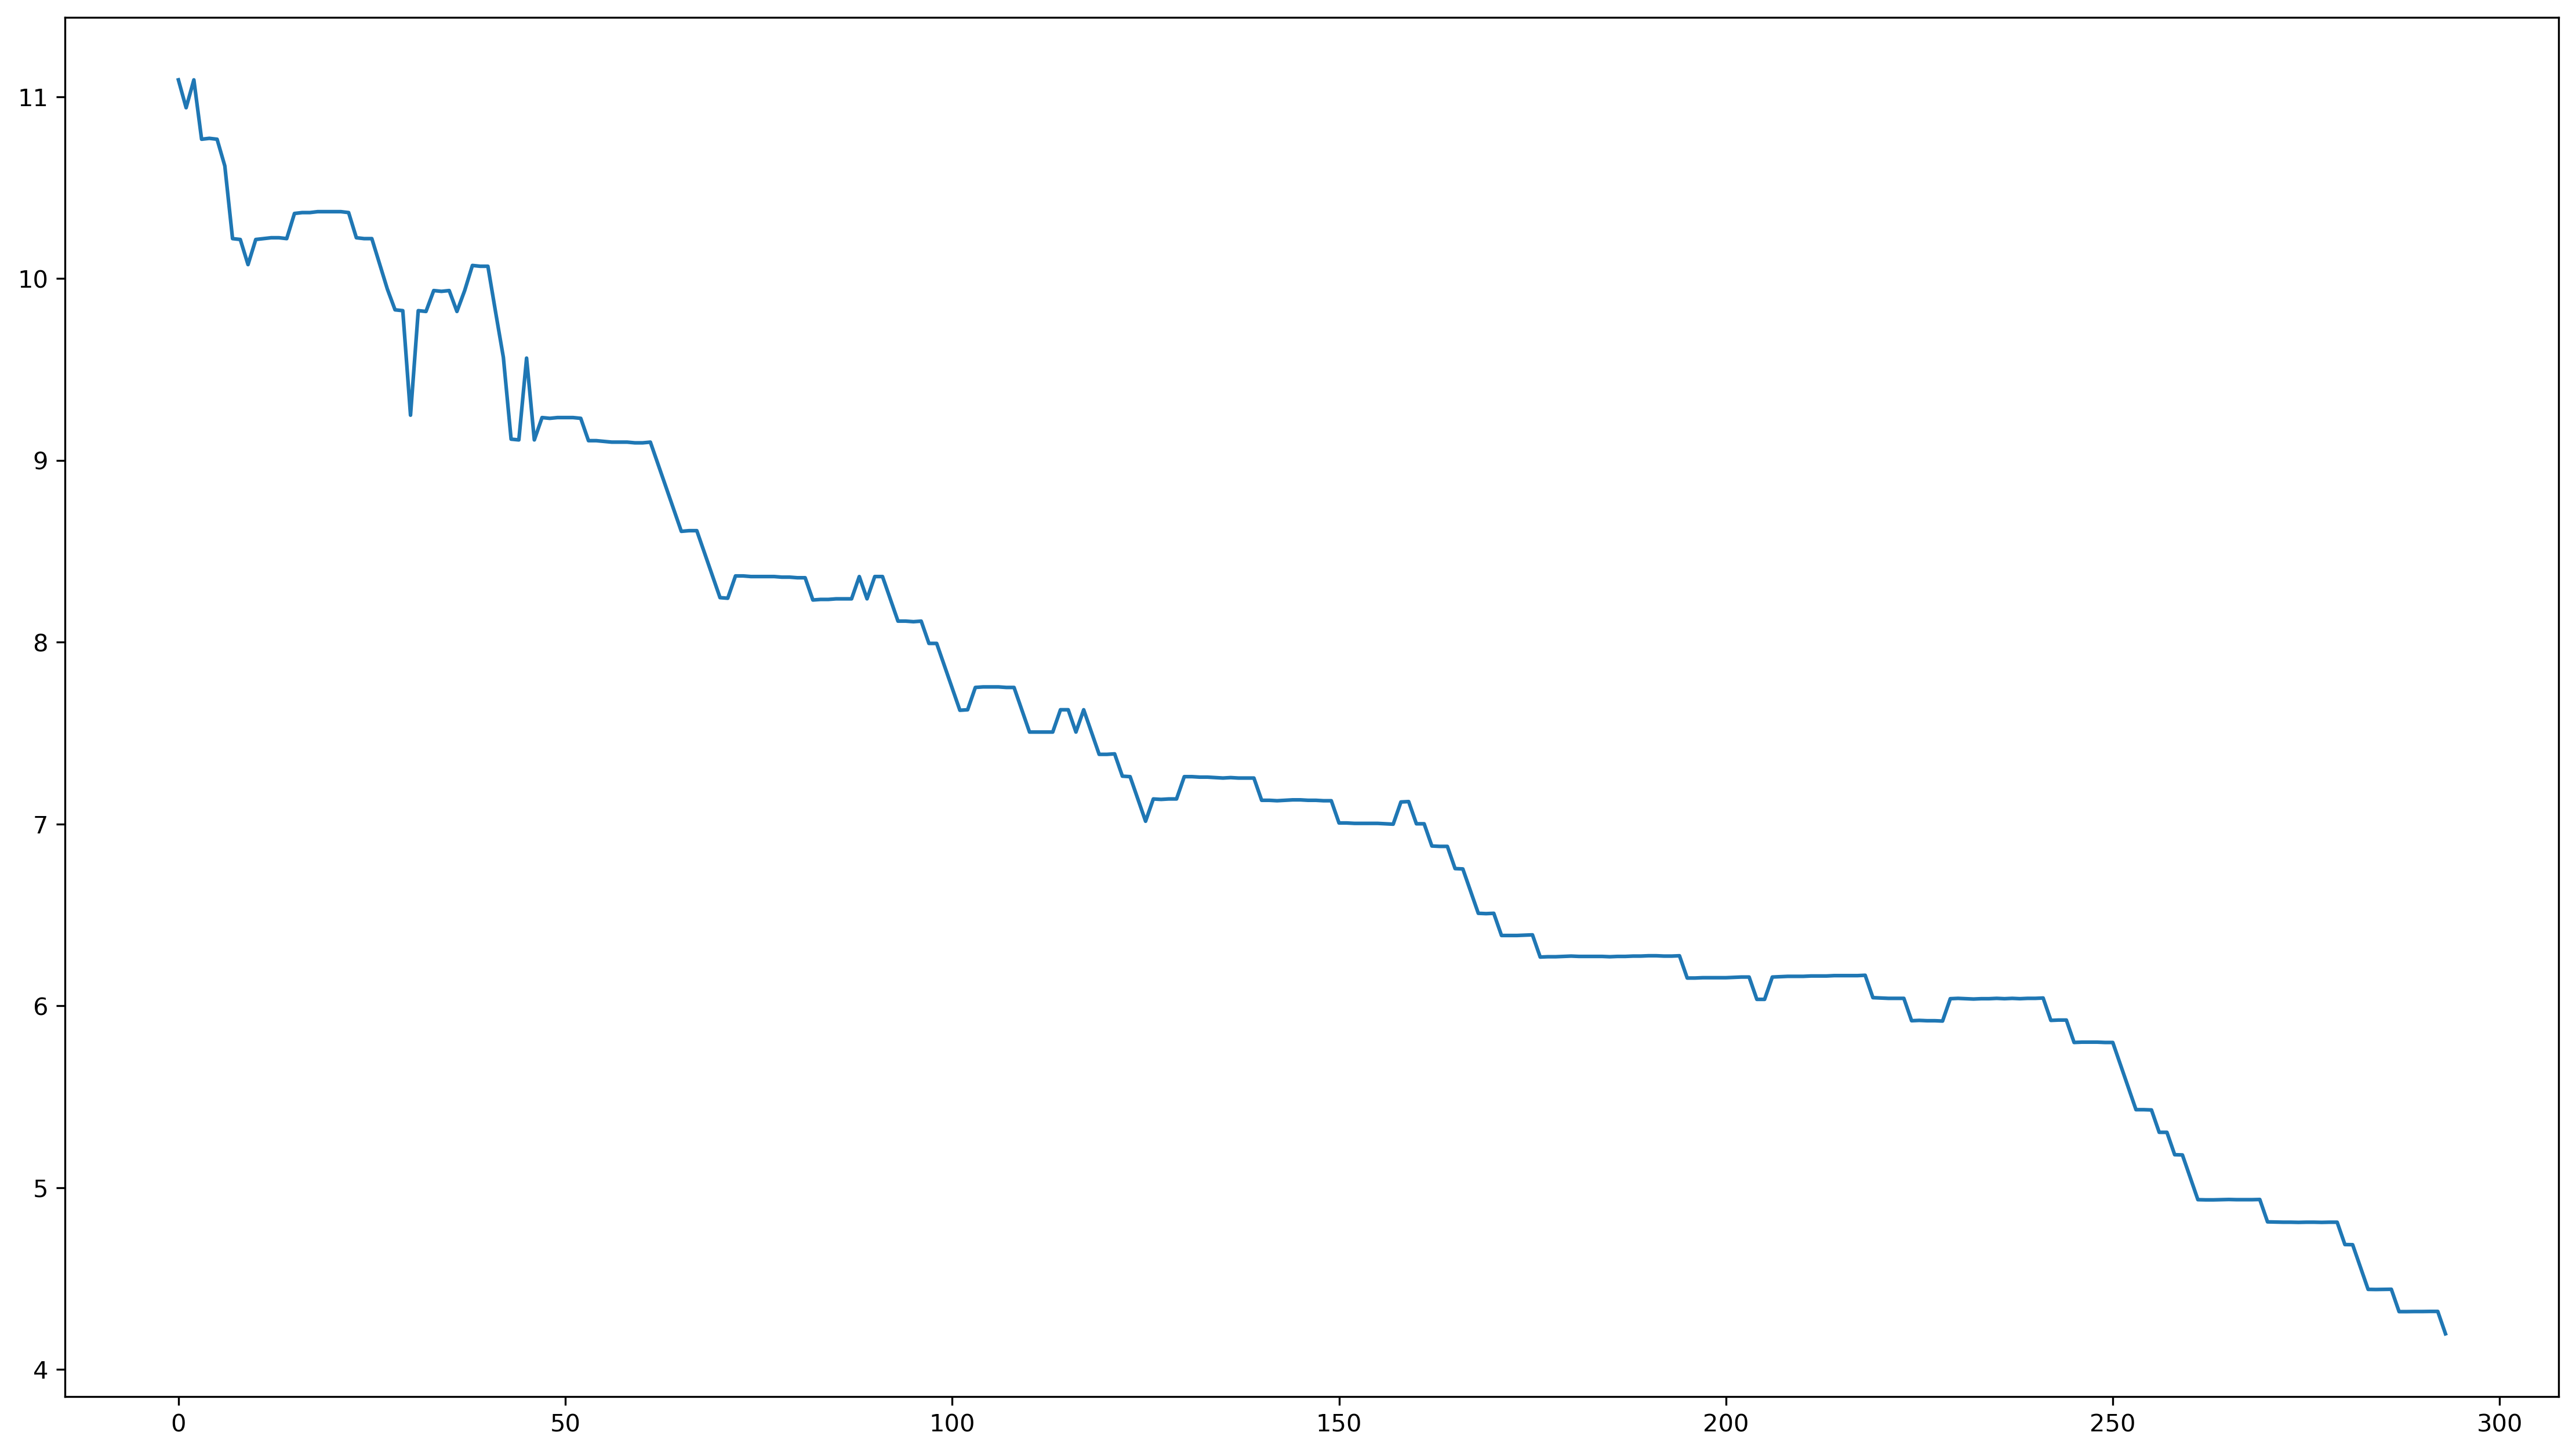

In [207]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)
#plt.savefig('yoooo_op_og_ned_hva_1.pdf')  

In [214]:
best_ps_config[0].period

1900

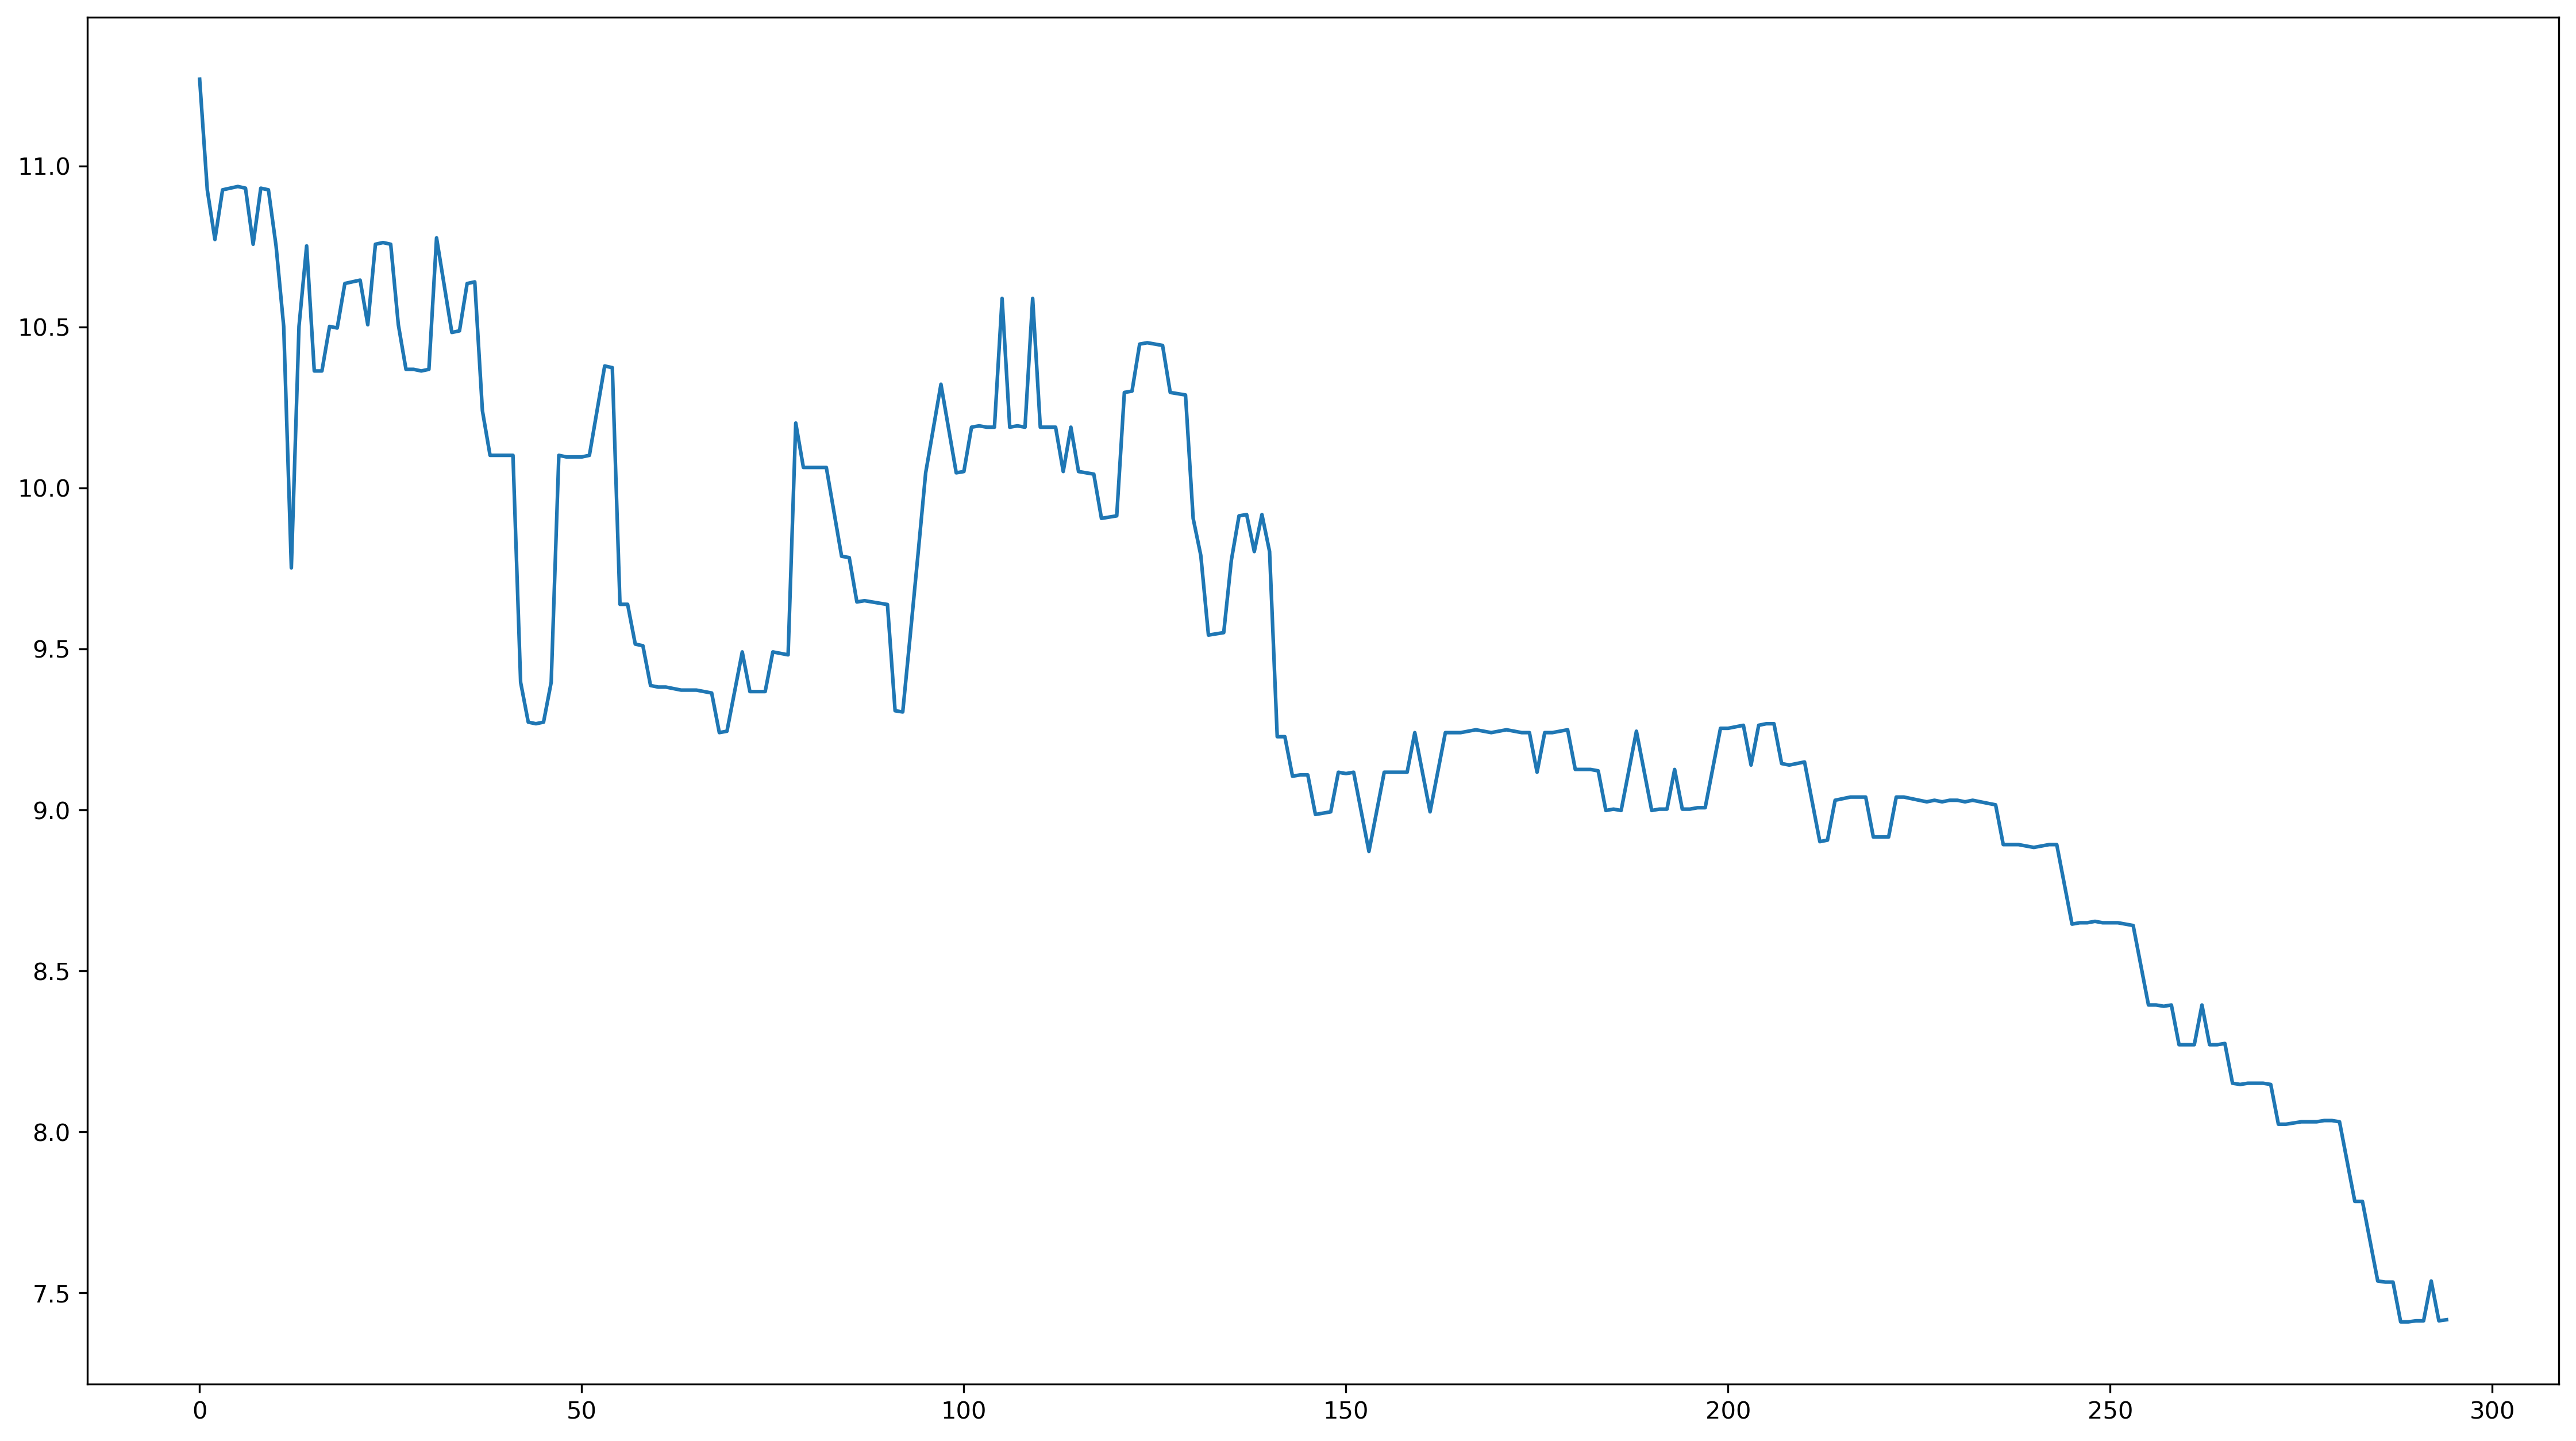

In [205]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(cost_log)), cost_log)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(300)
#plt.savefig('yoooo_op_og_ned_hva_1.pdf')  

In [199]:
print(cost_best)

8.394189393939396


In [ ]:
type(tt_tasks[-1].et_subset)

In [ ]:
tt_tasks[-1].deadline
print("name: ", tt_tasks[-1].name, " duration: ", tt_tasks[-1].duration, " deadline: ", tt_tasks[-1].deadline, " period: ", tt_tasks[-1].period, tt_tasks[-1].release_time)
    d = calculate_schedulabiltiy(polling_servers_0[0], polling_servers_0[0].et_subset)
    

In [ ]:
#edf(tt_tasks)

In [ ]:
#calculate_schedulabiltiy(tt_tasks[-1], tt_tasks[-1].et_subset)

In [ ]:
p(3.5, 100)

In [110]:
tt_tasks = [t for t in all_tasks if t.type == TaskType.TIME]
et_tasks = [t for t in all_tasks if t.type == TaskType.EVENT]
polling_servers_0 = [Task("tTTps00", 1000, 1000, TaskType.TIME, 7, 1000, et_tasks)]

In [111]:
calculate_schedulabiltiy(polling_servers_0[0], polling_servers_0[0].et_subset)

{'tET8': (True, 0),
 'tET13': (True, 0),
 'tET0': (True, 0),
 'tET19': (True, 0),
 'tET5': (True, 0),
 'tET4': (True, 0),
 'tET16': (True, 0),
 'tET1': (True, 0),
 'tET2': (True, 0),
 'tET18': (True, 0),
 'tET14': (True, 0),
 'tET15': (True, 0),
 'tET6': (True, 0),
 'tET11': (True, 0),
 'tET12': (True, 0),
 'tET7': (True, 0),
 'tET3': (True, 0),
 'tET17': (True, 0),
 'tET9': (True, 0),
 'tET10': (True, 0)}

In [ ]:
s, cost_ = cost(tt_tasks + polling_servers_0)

In [ ]:
edf_old(tt_tasks + polling_servers_0)

In [ ]:
cost_

In [ ]:
# ts is set of TT tasks
def edf_old(ts):
    
    periods = [t.period for t in ts]
    T = math.lcm(*periods) # least common multiple of TT task periods. 2000 mt = 
    #print(T)
    S = [] # schedule will be hyperperiod long. 12 000 microticks == 120 000 microsecs == 120 ms
    ready_list = []
    wcrts = {} # worst case response times
    
    # overvej reset funktioner i task klassen istedet for alle de kopier...
    for t in range(0, T):
        ready_list = get_ready(ts, t, ready_list)
        
        for task in ready_list:
            if task.duration > 0 and task.deadline <= t:
                return [], -1
        
            # job done check response time gt wcrt and remove from ready list
            if task.duration == 0 and task.deadline >= t:
                response_time = t - task.release_time
                
                if task.name not in wcrts or response_time >= wcrts[task.name]:
                    wcrts[task.name] = response_time
                
                ready_list.remove(task)
                
            
        if ready_list == []:
            S.append("IDLE")
            continue
        else:
            # EDF get next job to execute 
            S.append(ready_list[0].name)
            ready_list[0].duration = ready_list[0].duration - 1
    
    if ready_list != []:
        return [], wcrts
    
    return S, wcrts

In [ ]:
polling_servers_0 = [Task("tTTps00", 20, 40, TaskType.TIME, 7, 999, et_tasks)]

In [ ]:
edf_old(tt_tasks + polling_servers_0)

In [28]:
type(copy.deepcopy(tt_tasks + polling_servers_0))

list

In [101]:
5 < float('inf')

True

In [112]:
d = calculate_schedulabiltiy(polling_servers_0[0], polling_servers_0[0].et_subset)

In [114]:
b = False 
for key in d:
    b = True
    b = b and d[key][0] 
    if not d[key][0]:
        print(key)

In [115]:
b

True

In [172]:
"""
is_good = False 
while not is_good:
    polling_servers_0 = [Task("tTTps00", rand.randint(1, 1000), rand.randint(1, 10000), TaskType.TIME, 7, rand.randint(1, 10000), et_tasks)]
    d = calculate_schedulabiltiy(polling_servers_0[0], polling_servers_0[0].et_subset)
    
    is_good = True
    is_good = is_good and d[key][0]
    is_good = is_good and polling_servers_0[0].duration <= polling_servers_0[0].deadline
    is_good = is_good and polling_servers_0[0].period <= polling_servers_0[0].deadline
"""

'\nis_good = False \nwhile not is_good:\n    polling_servers_0 = [Task("tTTps00", rand.randint(1, 1000), rand.randint(1, 10000), TaskType.TIME, 7, rand.randint(1, 10000), et_tasks)]\n    d = calculate_schedulabiltiy(polling_servers_0[0], polling_servers_0[0].et_subset)\n    \n    is_good = True\n    is_good = is_good and d[key][0]\n    is_good = is_good and polling_servers_0[0].duration <= polling_servers_0[0].deadline\n    is_good = is_good and polling_servers_0[0].period <= polling_servers_0[0].deadline\n'

In [201]:
#p(0.12259259259259636, )

0.9405445186286537

In [312]:
best_ps_config[0].period

1000

In [311]:
calculate_schedulabiltiy(best_ps_config[0], best_ps_config[0].et_subset)

{'tET8': (False, 3848),
 'tET13': (False, 3825),
 'tET0': (False, 11675),
 'tET19': (False, 11675),
 'tET5': (False, 5847),
 'tET4': (False, 5337),
 'tET16': (False, 5337),
 'tET1': (False, 5337),
 'tET2': (False, 3634),
 'tET18': (False, 3634),
 'tET14': (False, 3634),
 'tET15': (False, 3634),
 'tET6': (False, 3634),
 'tET11': (False, 2654),
 'tET12': (False, 2654),
 'tET7': (False, 2654),
 'tET3': (False, 2654),
 'tET17': (False, 2654),
 'tET9': (False, 2654),
 'tET10': (False, 2654)}

In [84]:
l = [True, True, True, False]
init = True
init = init and reduce((lambda a, b : a and b), [x for x in l])


In [86]:
d = {}
d[1] = 2
d[2] = 1
len(d)

2

In [14]:
for i in range(10, 1, -1):
    print(i)

10
9
8
7
6
5
4
3
2
